In [ ]:
!pip install tensorflow==2.15.0
!pip install tensorflow-quantum==0.7.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.3/475.3 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 5.9 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.0
    Uninstalling wrapt-1.17.0:
      Successfully uninstalled wrapt-1.17.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0
  Attempting uninstall: tensorboard
    Found existing installation

Training set shape: (1500, 28, 28)
Training labels shape: (1500,)
Test set shape: (3147, 28, 28)
Test labels shape: (3147,)
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


10/10 [==============================] - ETA: 0s - loss: 1.0192 - accuracy: 0.4375 
Epoch 1: val_loss improved from inf to 1.77439, saving model to best_model_mnist_c3_500.h5
10/10 [==============================] - 119s 12s/step - loss: 1.0192 - accuracy: 0.4375 - val_loss: 1.7744 - val_accuracy: 0.0567 - lr: 0.0099
Epoch 2/50
10/10 [==============================] - ETA: 0s - loss: 0.8972 - accuracy: 0.6433 
Epoch 2: val_loss improved from 1.77439 to 1.48482, saving model to best_model_mnist_c3_500.h5
10/10 [==============================] - 115s 11s/step - loss: 0.8972 - accuracy: 0.6433 - val_loss: 1.4848 - val_accuracy: 0.2033 - lr: 0.0098
Epoch 3/50
10/10 [==============================] - ETA: 0s - loss: 0.7981 - accuracy: 0.7283 
Epoch 3: val_loss improved from 1.48482 to 1.36568, saving model to best_model_mnist_c3_500.h5
10/10 [==============================] - 115s 11s/step - loss: 0.7981 - accuracy: 0.7283 - val_loss: 1.3657 - val_accuracy: 0.3500 - lr: 0.0097
Epoch 4/50
10

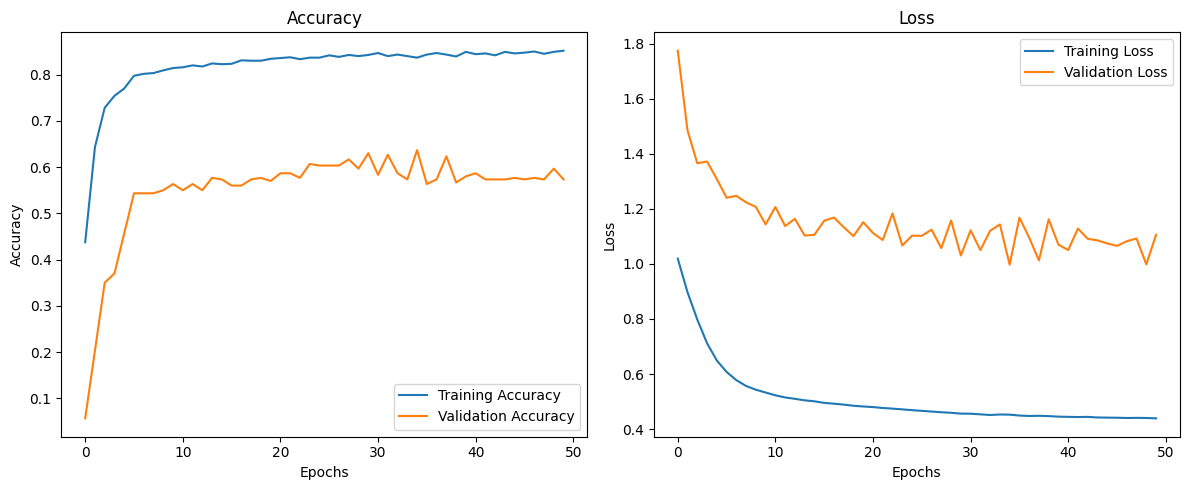

99/99 [==============================] - 43s 432ms/step


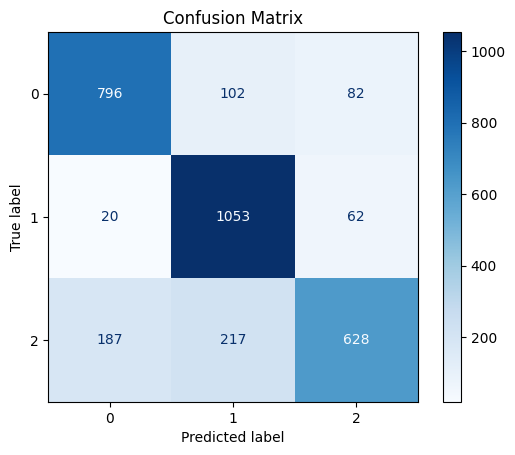

NameError: name 'precision_score' is not defined

In [ ]:
import tensorflow as tf
import tensorflow_quantum as tfq
import cirq
import numpy as np
import sympy
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

# Load the Fashion MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Filter dataset for three classes
selected_classes = [0, 1, 2]  # Modify to include three classes: e.g., 0 = T-shirt/top, 1 = Trouser, 2 = Pullover
train_filter = np.isin(y_train, selected_classes)
test_filter = np.isin(y_test, selected_classes)

x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]

# Preprocess the dataset: normalize and downscale
x_train = x_train / 255.0  # Normalize
x_test = x_test / 255.0

class_limit = 500
x_train_limited, y_train_limited = [], []

for cls in selected_classes:
    cls_indices = np.where(y_train == cls)[0][:class_limit]
    x_train_limited.append(x_train[cls_indices])
    y_train_limited.append(y_train[cls_indices])

# Concatenate arrays
x_train_limited = np.concatenate(x_train_limited)
y_train_limited = np.concatenate(y_train_limited)

# Assign back to training set
x_train, y_train = x_train_limited, y_train_limited

# Display shapes of processed datasets
print("Training set shape:", x_train.shape)  # Output: (number_of_samples, 28, 28)
print("Training labels shape:", y_train.shape)  # Output: (number_of_samples,)
print("Test set shape:", x_test.shape)  # Output: (number_of_test_samples, 28, 28)
print("Test labels shape:", y_test.shape)  # Output: (number_of_test_samples,)

# No need to convert labels for binary classification; retain original class labels for multi-class classification

# Further reduce dimensions for quantum efficiency (4x4 grid)
def preprocess_images(images, size=4):
    images = tf.image.resize(images[..., tf.newaxis], (size, size)).numpy()
    return images.reshape(-1, size**2)

x_train = preprocess_images(x_train)
x_test = preprocess_images(x_test)


# Define the quantum circuit
def create_quantum_circuit(qubits, params,layers):
    circuit = cirq.Circuit()
    for layer_num in range(layers):
      for i, qubit in enumerate(qubits):
          circuit.append(cirq.rz(params[i + layer_num] )(qubit))
          circuit.append(cirq.ry(params[i + len(qubits) + layer_num ] )(qubit))
          circuit.append(cirq.rz(params[i + 2*len(qubits) + 3*len(qubits)  + layer_num ])(qubit))
      for i in range(len(qubits) - 1):
          circuit.append(cirq.CZ(qubits[i], qubits[i + 1]))
    return circuit

# Create qubits and symbolic parameters
n_qubits = 16
layers = 3
qubits = [cirq.GridQubit(i, 0) for i in range(n_qubits)]
params = sympy.symbols(f'theta_0:{3*n_qubits*layers }')

# Generate a quantum circuit
example_circuit = create_quantum_circuit(qubits, params,layers)



# Convert circuits to TensorFlow Quantum Tensors



# Convert circuits to TensorFlow Quantum Tensors
def create_quantum_data(images):
    circuits = []
    for image in images:
        circuit = cirq.Circuit()
        for i, pixel in enumerate(image):
            circuit.append(cirq.rx(np.pi * pixel)(qubits[i % n_qubits]))
        circuits.append(circuit)
    return tfq.convert_to_tensor(circuits)

x_train_circuits = create_quantum_data(x_train)
x_test_circuits = create_quantum_data(x_test)


# Define the learning rate schedule
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01, decay_steps=100, decay_rate=0.9
)

# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001
)

# Define the hybrid quantum-classical model using Functional API
def create_model():
    # Input layer
    quantum_input = tf.keras.Input(shape=(), dtype=tf.string, name='quantum_input')

    # Quantum layer
    quantum_layer = tfq.layers.PQC(example_circuit, [cirq.Z(q) for q in qubits])(quantum_input)

    # Dense layer with softmax for multi-class classification
    output = tf.keras.layers.Dense(len(selected_classes), activation="softmax")(quantum_layer)

    # Define the model
    model = tf.keras.Model(inputs=quantum_input, outputs=output, name='Quantum_Classifier')
    return model




model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "best_model_mnist_c3_500.h5", monitor="val_loss", save_best_only=True, save_weights_only=True, verbose=1
)

# Create and compile the model
model = create_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)



# Train the model
history = model.fit(
    x_train_circuits, y_train,
    epochs=50,
    batch_size=128,
    validation_split=0.2,
    callbacks=[ model_checkpoint, reduce_lr]
)

# Load the best model weights
# Changed filename to match the one specified in ModelCheckpoint callback
model.load_weights("best_model_mnist_c3_500.h5")

# Evaluate the model
loss, accuracy = model.evaluate(x_test_circuits, y_test)
print(f"Test accuracy: {accuracy:.2f}")

# Plot accuracy and loss
def plot_history(history):
    plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)

# Confusion matrix
y_pred = np.argmax(model.predict(x_test_circuits), axis=1)
cm = confusion_matrix(y_test, y_pred, labels=range(len(selected_classes)))
ConfusionMatrixDisplay(cm, display_labels=selected_classes).plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()



# Calculate precision, recall, and F1-score
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


11490434/11490434 [==============================] - 0s 0us/step
Training set shape: (3000, 28, 28)
Training labels shape: (3000,)
Test set shape: (3147, 28, 28)
Test labels shape: (3147,)
Epoch 1/50
19/19 [==============================] - ETA: 0s - loss: 1.0720 - accuracy: 0.4708 
Epoch 1: val_loss improved from inf to 1.87302, saving model to best_model_mnist_c3_1000.h5
19/19 [==============================] - 235s 12s/step - loss: 1.0720 - accuracy: 0.4708 - val_loss: 1.8730 - val_accuracy: 0.0500 - lr: 0.0098
Epoch 2/50
19/19 [==============================] - ETA: 0s - loss: 0.8311 - accuracy: 0.6787 
Epoch 2: val_loss improved from 1.87302 to 1.82402, saving model to best_model_mnist_c3_1000.h5
19/19 [==============================] - 236s 12s/step - loss: 0.8311 - accuracy: 0.6787 - val_loss: 1.8240 - val_accuracy: 0.0433 - lr: 0.0096
Epoch 3/50
19/19 [==============================] - ETA: 0s - loss: 0.7078 - accuracy: 0.7079 
Epoch 3: val_loss improved from 1.82402 to 1.44390

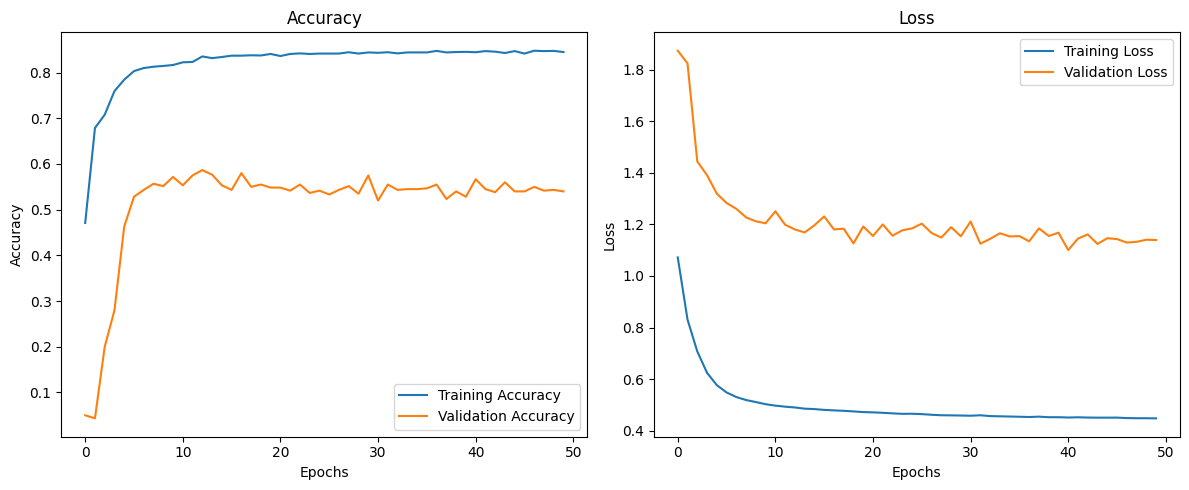

99/99 [==============================] - 43s 428ms/step


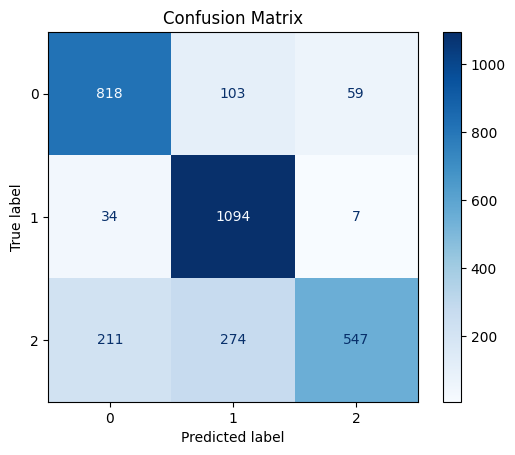

NameError: name 'precision_score' is not defined

In [ ]:
import tensorflow as tf
import tensorflow_quantum as tfq
import cirq
import numpy as np
import sympy
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

# Load the Fashion MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Filter dataset for three classes
selected_classes = [0, 1, 2]  # Modify to include three classes: e.g., 0 = T-shirt/top, 1 = Trouser, 2 = Pullover
train_filter = np.isin(y_train, selected_classes)
test_filter = np.isin(y_test, selected_classes)

x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]

# Preprocess the dataset: normalize and downscale
x_train = x_train / 255.0  # Normalize
x_test = x_test / 255.0

class_limit = 1000
x_train_limited, y_train_limited = [], []

for cls in selected_classes:
    cls_indices = np.where(y_train == cls)[0][:class_limit]
    x_train_limited.append(x_train[cls_indices])
    y_train_limited.append(y_train[cls_indices])

# Concatenate arrays
x_train_limited = np.concatenate(x_train_limited)
y_train_limited = np.concatenate(y_train_limited)

# Assign back to training set
x_train, y_train = x_train_limited, y_train_limited

# Display shapes of processed datasets
print("Training set shape:", x_train.shape)  # Output: (number_of_samples, 28, 28)
print("Training labels shape:", y_train.shape)  # Output: (number_of_samples,)
print("Test set shape:", x_test.shape)  # Output: (number_of_test_samples, 28, 28)
print("Test labels shape:", y_test.shape)  # Output: (number_of_test_samples,)

# No need to convert labels for binary classification; retain original class labels for multi-class classification

# Further reduce dimensions for quantum efficiency (4x4 grid)
def preprocess_images(images, size=4):
    images = tf.image.resize(images[..., tf.newaxis], (size, size)).numpy()
    return images.reshape(-1, size**2)

x_train = preprocess_images(x_train)
x_test = preprocess_images(x_test)


# Define the quantum circuit
def create_quantum_circuit(qubits, params,layers):
    circuit = cirq.Circuit()
    for layer_num in range(layers):
      for i, qubit in enumerate(qubits):
          circuit.append(cirq.rz(params[i + layer_num] )(qubit))
          circuit.append(cirq.ry(params[i + len(qubits) + layer_num ] )(qubit))
          circuit.append(cirq.rz(params[i + 2*len(qubits) + 3*len(qubits)  + layer_num ])(qubit))
      for i in range(len(qubits) - 1):
          circuit.append(cirq.CZ(qubits[i], qubits[i + 1]))
    return circuit

# Create qubits and symbolic parameters
n_qubits = 16
layers = 3
qubits = [cirq.GridQubit(i, 0) for i in range(n_qubits)]
params = sympy.symbols(f'theta_0:{3*n_qubits*layers }')

# Generate a quantum circuit
example_circuit = create_quantum_circuit(qubits, params,layers)



# Convert circuits to TensorFlow Quantum Tensors



# Convert circuits to TensorFlow Quantum Tensors
def create_quantum_data(images):
    circuits = []
    for image in images:
        circuit = cirq.Circuit()
        for i, pixel in enumerate(image):
            circuit.append(cirq.rx(np.pi * pixel)(qubits[i % n_qubits]))
        circuits.append(circuit)
    return tfq.convert_to_tensor(circuits)

x_train_circuits = create_quantum_data(x_train)
x_test_circuits = create_quantum_data(x_test)


# Define the learning rate schedule
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01, decay_steps=100, decay_rate=0.9
)

# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001
)

# Define the hybrid quantum-classical model using Functional API
def create_model():
    # Input layer
    quantum_input = tf.keras.Input(shape=(), dtype=tf.string, name='quantum_input')

    # Quantum layer
    quantum_layer = tfq.layers.PQC(example_circuit, [cirq.Z(q) for q in qubits])(quantum_input)

    # Dense layer with softmax for multi-class classification
    output = tf.keras.layers.Dense(len(selected_classes), activation="softmax")(quantum_layer)

    # Define the model
    model = tf.keras.Model(inputs=quantum_input, outputs=output, name='Quantum_Classifier')
    return model




model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "best_model_mnist_c3_1000.h5", monitor="val_loss", save_best_only=True, save_weights_only=True, verbose=1
)

# Create and compile the model
model = create_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)



# Train the model
history = model.fit(
    x_train_circuits, y_train,
    epochs=50,
    batch_size=128,
    validation_split=0.2,
    callbacks=[ model_checkpoint, reduce_lr]
)

# Load the best model weights
# Changed filename to match the one specified in ModelCheckpoint callback
model.load_weights("best_model_mnist_c3_1000.h5")

# Evaluate the model
loss, accuracy = model.evaluate(x_test_circuits, y_test)
print(f"Test accuracy: {accuracy:.2f}")

# Plot accuracy and loss
def plot_history(history):
    plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)

# Confusion matrix
y_pred = np.argmax(model.predict(x_test_circuits), axis=1)
cm = confusion_matrix(y_test, y_pred, labels=range(len(selected_classes)))
ConfusionMatrixDisplay(cm, display_labels=selected_classes).plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()



# Calculate precision, recall, and F1-score
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
